In [193]:
import numpy as np 
import pandas as pd 
from IPython.display import display
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk
import os
import random
import os, sys, email, re
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

In [37]:
path_csv = r'D:\emails.csv'

In [38]:
# df = pd.read_csv(r'D:\emails.csv', nrows = 50000)
# df = pd.read_csv('home/saba/Enron/Data/Archive/emails.csv',nrows = 50000)

total_rows = 517401
random_sample = 10000
lines_to_skip = np.random.choice(np.arange(1,total_rows+1), (total_rows-random_sample),replace=False)

df = pd.read_csv(path_csv, skiprows = lines_to_skip)

In [39]:
df.head()

,file,message
0,allen-p/_sent_mail/123.,Message-ID: <19330146.1075855687961.JavaMail.e...
1,allen-p/_sent_mail/146.,Message-ID: <20163768.1075855688465.JavaMail.e...
2,allen-p/_sent_mail/150.,Message-ID: <12637670.1075855688550.JavaMail.e...
3,allen-p/_sent_mail/219.,Message-ID: <26723744.1075855690050.JavaMail.e...
4,allen-p/_sent_mail/244.,Message-ID: <28925215.1075855690588.JavaMail.e...


In [40]:
# create list of email objects

emails = list(map(email.parser.Parser().parsestr, df['message']))

In [41]:
print(emails[2].keys())

['Message-ID', 'Date', 'From', 'To', 'Subject', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding', 'X-From', 'X-To', 'X-cc', 'X-bcc', 'X-Folder', 'X-Origin', 'X-FileName']


In [42]:
#extract headings
headings = emails[0].keys()

#extract values for each key/heading
for key in headings:
    df[key] = [x[key] for x in emails]

In [50]:
#make content column and user column
def get_raw_text(emails):
    email_text = []
    for email in emails.walk():
        if email.get_content_type() == 'text/plain':
            email_text.append(email.get_payload())
    return ''.join(email_text)

df['content'] = list(map(get_raw_text, emails))

df['user']= df['file'].map(lambda x: x.split('/')[0])

In [52]:
df.head(2)

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/123.,Message-ID: <19330146.1075855687961.JavaMail.e...,<19330146.1075855687961.JavaMail.evans@thyme>,"Tue, 26 Sep 2000 04:57:00 -0700 (PDT)",phillip.allen@enron.com,jsmith@austintx.com,closing,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,Phillip K Allen,jsmith@austintx.com,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,---------------------- Forwarded by Phillip K ...,allen-p
1,allen-p/_sent_mail/146.,Message-ID: <20163768.1075855688465.JavaMail.e...,<20163768.1075855688465.JavaMail.evans@thyme>,"Fri, 8 Sep 2000 05:29:00 -0700 (PDT)",phillip.allen@enron.com,pallen70@hotmail.com,Westgate Proforma-Phillip Allen.xls,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,pallen70@hotmail.com,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,---------------------- Forwarded by Phillip K ...,allen-p


In [55]:
#change Date type from object to datetime
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format = True, utc=True)
df.dtypes

file                                      object
message                                   object
Message-ID                                object
Date                         datetime64[ns, UTC]
From                                      object
To                                        object
Subject                                   object
Mime-Version                              object
Content-Type                              object
Content-Transfer-Encoding                 object
X-From                                    object
X-To                                      object
X-cc                                      object
X-bcc                                     object
X-Folder                                  object
X-Origin                                  object
X-FileName                                object
content                                   object
user                                      object
dtype: object

In [67]:
#make day, time, month and year columns 
df['Day'] = df['Date'].dt.day
df['Dayofweek'] = df['Date'].dt.strftime('%A')
df['Month']= df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Time'] = df['Date'].dt.strftime('%H:%M')

In [68]:
df.head()

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,X-Folder,X-Origin,X-FileName,content,user,Day,Month,Year,Time,Dayofweek
0,allen-p/_sent_mail/123.,Message-ID: <19330146.1075855687961.JavaMail.e...,<19330146.1075855687961.JavaMail.evans@thyme>,2000-09-26 11:57:00+00:00,phillip.allen@enron.com,jsmith@austintx.com,closing,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,...,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,---------------------- Forwarded by Phillip K ...,allen-p,26,9,2000,11:57,Tuesday
1,allen-p/_sent_mail/146.,Message-ID: <20163768.1075855688465.JavaMail.e...,<20163768.1075855688465.JavaMail.evans@thyme>,2000-09-08 12:29:00+00:00,phillip.allen@enron.com,pallen70@hotmail.com,Westgate Proforma-Phillip Allen.xls,1.0,text/plain; charset=us-ascii,7bit,...,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,---------------------- Forwarded by Phillip K ...,allen-p,8,9,2000,12:29,Friday
2,allen-p/_sent_mail/150.,Message-ID: <12637670.1075855688550.JavaMail.e...,<12637670.1075855688550.JavaMail.evans@thyme>,2000-09-06 13:04:00+00:00,phillip.allen@enron.com,ina.rangel@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Ina,\n\n I scheduled a meeting with Jean Mrha ...",allen-p,6,9,2000,13:04,Wednesday
3,allen-p/_sent_mail/219.,Message-ID: <26723744.1075855690050.JavaMail.e...,<26723744.1075855690050.JavaMail.evans@thyme>,2000-07-11 16:24:00+00:00,phillip.allen@enron.com,ina.rangel@enron.com,Systems Meeting 7/18,1.0,text/plain; charset=us-ascii,7bit,...,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,---------------------- Forwarded by Phillip K ...,allen-p,11,7,2000,16:24,Tuesday
4,allen-p/_sent_mail/244.,Message-ID: <28925215.1075855690588.JavaMail.e...,<28925215.1075855690588.JavaMail.evans@thyme>,2000-06-13 10:32:00+00:00,phillip.allen@enron.com,matthew.lenhart@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,http://ectpdx-sunone.ect.enron.com/~theizen/ws...,allen-p,13,6,2000,10:32,Tuesday


In [82]:
print(df.Year.agg({'max': max, 'min': min}))
df.groupby('Year')['content'].count()

max    2004
min    1980
Name: Year, dtype: int64


Year
1980       8
1997       7
1998       3
1999     207
2000    3771
2001    5280
2002     721
2004       3
Name: content, dtype: int64

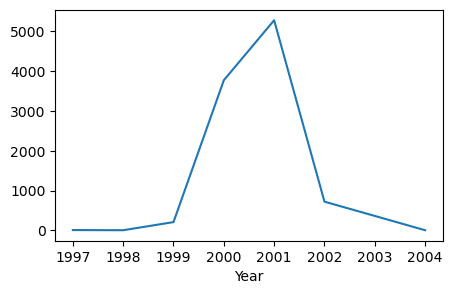

In [78]:
# the total count of emails increased in 2000 and 2001 so lets take a smaller subset in terms of years.
indices = (df['Year'] > 1995) & (df['Year'] <= 2004)
plt.figure(figsize = (5,3))
figure1 = df.loc[indices].groupby('Year')['content'].count().plot()

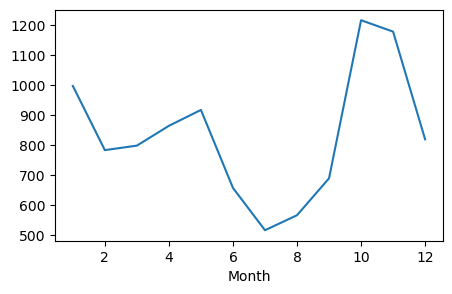

In [86]:
plt.figure(figsize = (5,3))
figure2 = df.groupby('Month')['content'].count().plot()


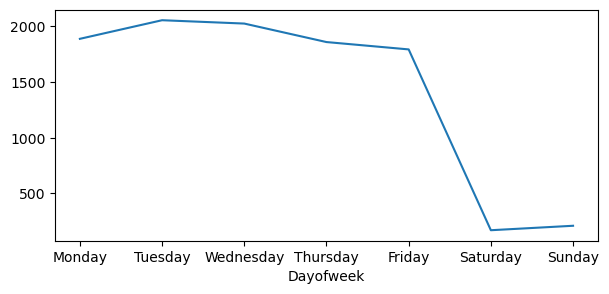

In [99]:
ordered_days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize = (7,3))
figure3 = df.groupby('Dayofweek')['content'].count().reindex(ordered_days).plot()

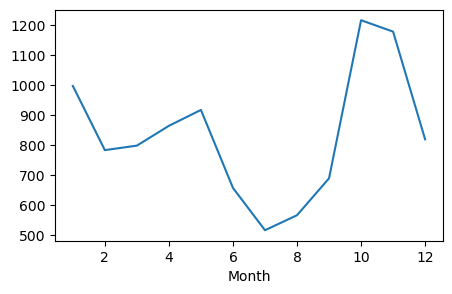

In [100]:
plt.figure(figsize = (5,3))
figure2 = df.groupby('Month')['content'].count().plot()

In [102]:
print('Total number of emails: %d' %len(df))
print('------------')
print('Number of unique received: %d '%df['To'].nunique())
print('------------')
print('Number of unique sent: %d '%df['From'].nunique())

Total number of emails: 10000
------------
Number of unique received: 5003 
------------
Number of unique sent: 2771 


### top 10 senders and receivers

In [154]:
top_10_frequent = df.groupby('user')['file'].count().sort_values(ascending = False)[:15]
top_10_frequent


user
kaminski-v      570
dasovich-j      553
kean-s          521
mann-k          445
shackleton-s    374
jones-t         347
taylor-m        285
farmer-d        268
germany-c       260
beck-s          232
symes-k         214
nemec-g         202
rogers-b        148
scott-s         146
bass-e          144
Name: file, dtype: int64

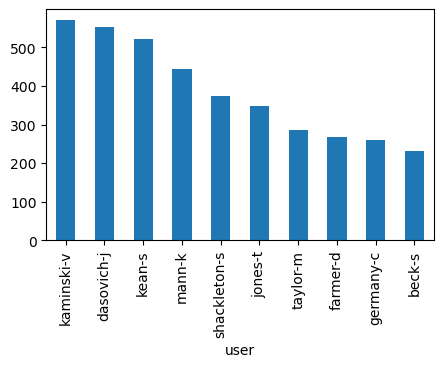

In [126]:
plt.figure(figsize = (5,3))
top_10_frequent.plot(kind = 'bar')

### Users and number of emails they sent by year.

In [133]:
df.groupby(['user', 'Year'])['file'].count()

user        Year
allen-p     1999     1
            2000    24
            2001    47
arnold-j    2000    44
            2001    52
                    ..
ybarbo-p    2001    32
zipper-a    2001    29
            2002     2
zufferli-j  2001     7
            2002     3
Name: file, Length: 342, dtype: int64

### one-on-one emails and multi-recepient 

In [135]:
df['To']

0                                     jsmith@austintx.com
1                                    pallen70@hotmail.com
2                                    ina.rangel@enron.com
3                                    ina.rangel@enron.com
4                               matthew.lenhart@enron.com
                              ...                        
9995                              rob.milnthorp@enron.com
9996                                 chuck.ames@enron.com
9997    j..taylor@enron.com, p..messenger@enron.com, m...
9998                                dmeyerhoeffer@mlp.com
9999    cooper.richey@enron.com, bill.greenizan@enron.com
Name: To, Length: 10000, dtype: object

In [145]:
def split_data(data):
    if data is not None:
        temp = data.split(',')
        if len(temp) == 1:
            return "Direct"
        else:
            return "Multiple"
    else:
        return "Empty"
    
df['Direct_or_multi'] = df['To'].apply(split_data)

In [148]:
df.tail(2)

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,X-Origin,X-FileName,content,user,Day,Month,Year,Time,Dayofweek,Direct_or_multi
9998,zufferli-j/sent_items/328.,Message-ID: <12907503.1075842036184.JavaMail.e...,<12907503.1075842036184.JavaMail.evans@thyme>,2001-06-20 21:07:00+00:00,john.zufferli@enron.com,dmeyerhoeffer@mlp.com,RE: Bleeding,1.0,text/plain; charset=us-ascii,7bit,...,ZUFFERLI-J,john zufferli 6-26-02.PST,I hope stock goes to $35 so I can buy it at re...,zufferli-j,20,6,2001,21:07,Wednesday,Direct
9999,zufferli-j/sent_items/333.,Message-ID: <20391686.1075842036339.JavaMail.e...,<20391686.1075842036339.JavaMail.evans@thyme>,2001-06-18 14:26:56+00:00,john.zufferli@enron.com,"cooper.richey@enron.com, bill.greenizan@enron.com",FW: Generator Maintenance Coordination Group M...,1.0,text/plain; charset=us-ascii,7bit,...,ZUFFERLI-J,john zufferli 6-26-02.PST,"\n\n -----Original Message-----\nFrom: \t""Ritt...",zufferli-j,18,6,2001,14:26,Monday,Multiple


In [155]:
x = df.groupby('user')['Direct_or_multi'].value_counts().sort_values(ascending=False)[:15]

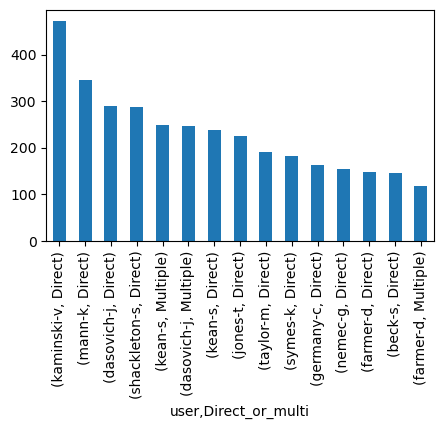

In [157]:
plt.figure(figsize = (5,3))
x.plot(kind = 'bar')

### Clean subject and content columns

In [160]:

def clean_column(data):
    if data is not None:
        stopwords_list = stopwords.words('english')
        #exclusions = ['RE:', 'Re:', 're:']
        #exclusions = '|'.join(exclusions)
        data =  data.lower()
        data = re.sub('re:', '', data)
        data = re.sub('-', '', data)
        data = re.sub('_', '', data)
        # Remove data between square brackets
        data =re.sub('\[[^]]*\]', '', data)
        # removes punctuation
        data = re.sub(r'[^\w\s]','',data)
        data = re.sub(r'\n',' ',data)
        data = re.sub(r'[0-9]+','',data)
        # strip html 
        p = re.compile(r'<.*?>')
        data = re.sub(r"\'ve", " have ", data)
        data = re.sub(r"can't", "cannot ", data)
        data = re.sub(r"n't", " not ", data)
        data = re.sub(r"I'm", "I am", data)
        data = re.sub(r" m ", " am ", data)
        data = re.sub(r"\'re", " are ", data)
        data = re.sub(r"\'d", " would ", data)
        data = re.sub(r"\'ll", " will ", data)
        data = re.sub('forwarded by phillip k allenhouect on    pm', '',data)
        data = re.sub(r"httpitcappscorpenroncomsrrsauthemaillinkaspidpage", "", data)
        
        data = p.sub('', data)
        if 'forwarded by:' in data:
            data = data.split('subject')[1]
        data = data.strip()
        return data
    return 'No Subject'


df['Subject_new'] = df['Subject'].apply(clean_column)
df['content_new'] = df['content'].apply(clean_column)

In [167]:
df.head()

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,content,user,Day,Month,Year,Time,Dayofweek,Direct_or_multi,Subject_new,content_new
0,allen-p/_sent_mail/123.,Message-ID: <19330146.1075855687961.JavaMail.e...,<19330146.1075855687961.JavaMail.evans@thyme>,2000-09-26 11:57:00+00:00,phillip.allen@enron.com,jsmith@austintx.com,closing,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,...,---------------------- Forwarded by Phillip K ...,allen-p,26,9,2000,11:57,Tuesday,Direct,closing,forwarded by phillip k allenhouect on am ...
1,allen-p/_sent_mail/146.,Message-ID: <20163768.1075855688465.JavaMail.e...,<20163768.1075855688465.JavaMail.evans@thyme>,2000-09-08 12:29:00+00:00,phillip.allen@enron.com,pallen70@hotmail.com,Westgate Proforma-Phillip Allen.xls,1.0,text/plain; charset=us-ascii,7bit,...,---------------------- Forwarded by Phillip K ...,allen-p,8,9,2000,12:29,Friday,Direct,westgate proformaphillip allenxls,george richards cbpresaustinrrcom on am plea...
2,allen-p/_sent_mail/150.,Message-ID: <12637670.1075855688550.JavaMail.e...,<12637670.1075855688550.JavaMail.evans@thyme>,2000-09-06 13:04:00+00:00,phillip.allen@enron.com,ina.rangel@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,"Ina,\n\n I scheduled a meeting with Jean Mrha ...",allen-p,6,9,2000,13:04,Wednesday,Direct,,ina i scheduled a meeting with jean mrha tom...
3,allen-p/_sent_mail/219.,Message-ID: <26723744.1075855690050.JavaMail.e...,<26723744.1075855690050.JavaMail.evans@thyme>,2000-07-11 16:24:00+00:00,phillip.allen@enron.com,ina.rangel@enron.com,Systems Meeting 7/18,1.0,text/plain; charset=us-ascii,7bit,...,---------------------- Forwarded by Phillip K ...,allen-p,11,7,2000,16:24,Tuesday,Direct,systems meeting,enron north america corp \t \tfrom kimberly h...
4,allen-p/_sent_mail/244.,Message-ID: <28925215.1075855690588.JavaMail.e...,<28925215.1075855690588.JavaMail.evans@thyme>,2000-06-13 10:32:00+00:00,phillip.allen@enron.com,matthew.lenhart@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,http://ectpdx-sunone.ect.enron.com/~theizen/ws...,allen-p,13,6,2000,10:32,Tuesday,Direct,,httpectpdxsunoneectenroncomtheizenwsccnav


In [177]:
## wordcloud needed to be installed in the base environment to work
# import sys
# print(sys.executable)
# !<C:\Users\Personal\anaconda3\python.exe>/python -m pip install wordcloud

C:\Users\Personal\anaconda3\python.exe


In [179]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
to_add = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa',
         'hou', 'cc', 'etc', 'subject', 'pm']

for i in to_add:
    stopwords.add(i)

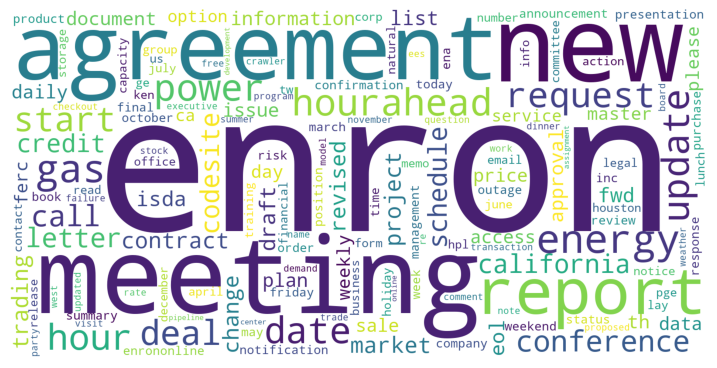

In [180]:
#size of each word indicates its frequency or importance.
wordcloud = WordCloud(
                          collocations = False,
                          width=1600, height=800,
                          background_color='white',
                          stopwords=stopwords,
                          max_words=150,
                          #max_font_size=40, 
                          random_state=42
                         ).generate(' '.join(df['Subject_new'])) # can't pass a series, needs to be strings and function computes frequencies
print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## TF-IDF transformation for K-means algorithm

“Term Frequency – Inverse Document” Frequency
Term Frequency: This summarizes how often a given word appears within a document.
Inverse Document Frequency: This downscales words that appear a lot across documents.

It is a statistic that aims to better define how important a word is for a document, while also taking into account the relation to other documents from the same corpus.
This is performed by looking at how many times a word appears into a document while also paying attention to how many times the same word appears in other documents in the corpus.

TF-IDF is a score which is applied to every word in every document in our dataset. And for every word, the TF-IDF value increases with every appearance of the word in a document, but is gradually decreased with every appearance in other documents

https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275

In [205]:
from sklearn.feature_extraction.text import TfidfVectorizer
data = df['content_new']
data.head()

0    forwarded by phillip k allenhouect on    am   ...
1    george richards cbpresaustinrrcom on   am plea...
2    ina   i scheduled a meeting with jean mrha tom...
3    enron north america corp \t \tfrom  kimberly h...
4            httpectpdxsunoneectenroncomtheizenwsccnav
Name: content_new, dtype: object

In [217]:
tf_idf_vectorizor = TfidfVectorizer(stop_words = stopwords, max_features = 5000)
%time tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

In [208]:
pd.set_option('display.max_columns',500)
df_tfidf.head(50)

,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,ab,abb,abc,ability,able,abraham,absence,absolutely,abx,ac,accept,acceptable,acceptance,accepted,access,accessing,accomplish,accordance,according,accordingly,account,accounting,accounts,accrual,accuracy,accurate,achieve,acknowledged,acquire,acquired,acquires,acquisition,acquisitions,acrobat,across,act,acting,action,actions,active,actively,activities,activity,acts,actual,actually,ad,adam,adams,add,added,adding,addition,additional,additionally,additions,address,addressed,addressee,addressees,addresses,addressing,adds,adequate,adjust,adjusted,adjustment,adjustments,admin,administration,administrative,administrator,adobe,adopted,ads,advance,advanced,advantage,adverse,advertisement,advertising,advice,advise,advised,advisor,advisory,advocate,advocates,aep,aes,affairs,affect,affected,affecting,affiliate,affiliates,afford,afternoon,ag,age,agencies,agency,agenda,agent,agents,ages,aggpwrii,aggressive,ago,agree,agreed,agreement,agreements,agrees,ahead,aid,air,aircraft,airline,airlines,airport,ak,al,alamo,alan,albert,alberta,alert,alerts,alex,alias,alignleft,alignleftfont,alignmiddlefont,alignrightfont,alignrighttdtd,alignrighttdtr,alleged,allegheny,allen,allenhouectect,alliance,allison,allocated,allocation,allocations,allow,allowed,allowing,allows,almost,alone,along,already,alt,alternate,alternative,alternatives,although,alumni,always,amanda,amend,amended,amendment,amendments,amerex,america,american,americans,americas,among,amount,amounts,amy,ana,analysis,analyst,analysts,anchorage,ancillary,andersen,anderson,andor,andrea,andrew,andy,angela,angeles,angie,anita,ann,anna,anne,annex,announce,announced,announcement,announces,annual,another,anr,answer,answers,anthony,anthrax,anticipate,anticipated,antitrust,antonio,anybody,anymore,anyone,anything,anytime,anyway,anywhere,aol,ap,apartment,apologies,apologize,app,apparent,apparently,appeal,appear,appeared,appears,applicable,application,applications,applied,applies,apply,appointed,appointment,appreciate,appreciated,approach,appropriate,approval,approvals,approve,approved,approving,approx,approximately,apr,...,using,usual,usually,ut,utilities,utility,utilitys,va,vacation,vacations,valid,valigntop,valley,valuable,valuation,value,valued,values,van,vance,vancouver,var,variance,variances,variety,various,vasant,ve,vegas,vehicle,vehicles,venture,ventures,venturewire,verify,vernon,veronica,version,versions,versus,via,vice,vicki,victor,video,view,viewed,viewing,views,village,vince,vincejkaminskienroncom,vincent,violation,violations,virginia,virtually,virus,viruses,vision,visit,visited,visiting,vkaminsenroncom,voice,voicemail,vol,volatile,volatility,volume,volumes,voluntary,volunteer,volunteers,vote,voted,votes,vp,vs,wa,wade,wait,waiting,waiver,walk,walker,wall,walter,walton,wanda,want,wanted,wants,war,warburg,ward,warehouse,warm,warned,warner,warning,warren,washington,wasnt,waste,watch,watching,water,watson,way,wayne,ways,weak,weakness,wear,weather,web,website,wed,wednesday,week,weekend,weekly,weeks,welcome,well,wellhead,wells,wendy,went,werent,wes,west,western,weve,wh,whalley,wharton,whatever,whats,whe,wheel,whenever,whether,white,whole,wholesale,whos,whose,wi,wide,width,widthimg,wife,will,william,williams,willing,wilson,win,wind,windfall,window,windows,winds,wine,winner,winners,winning,wins,winter,wire,wireless,wires,wish,wishes,wishing,withdrawn,withholding,within,without,wo,woes,wolfe,woman,women,won,wonder,wonderful,wondering,wont,wood,woods,word,words,work,worked,workers,working,works,worksheet,workshop,world,worldcom,worlds,worldwide,worried,worry,worse,worst,worth,wouldnt,wpd,wr,wrap,wright,write,writer,writers,writes,writing,written,wrong,wrote,wscc,xls,xmailer,xms,xx,yahoo,yards,year,yearend,years,yen,yes,yesterday,yesterdays,yet,yield,yo,york,youd,youll,young,youre,youve,zero,zimin,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084079,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [218]:
initial_centroids = np.random.permutation(tf_idf_array.shape[0])[:3]
initial_centroids
centroids = tf_idf_array[initial_centroids]
centroids.shape
dist_to_centroid =  pairwise_distances(tf_idf_array,centroids, metric = 'euclidean')
cluster_labels = np.argmin(dist_to_centroid, axis = 1)

In [189]:
cluster_labels

array([1, 1, 1, ..., 0, 2, 0], dtype=int64)

array([-2.30970265,  5.8496944 ])

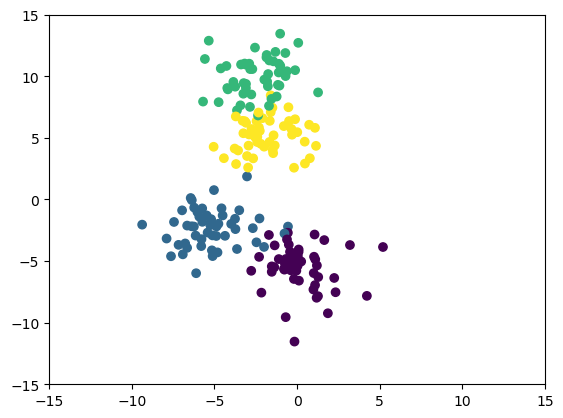

In [209]:
from sklearn.datasets import make_blobs
# create blobs
data = make_blobs(n_samples=200, n_features=2, centers=4, cluster_std=1.6, random_state=50)
# create np array for data points
points = data[0]
# create scatter plot
plt.scatter(data[0][:,0], data[0][:,1], c=data[1], cmap='viridis')
plt.xlim(-15,15)
plt.ylim(-15,15)

X = data[0]
X[2]

Wall time: 208 ms


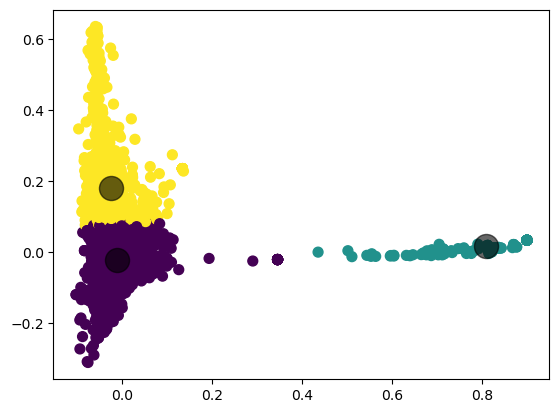

In [210]:
from sklearn.cluster import KMeans

n_clusters = 3
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters= n_clusters, max_iter=600, algorithm = 'auto')
%time fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);

### Elbow method for optimal clusters

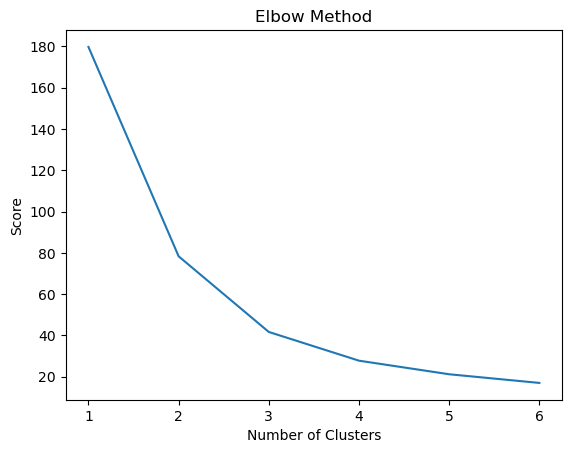

In [211]:
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score = [i*-1 for i in score]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

### Extracting top features

In [220]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 20)

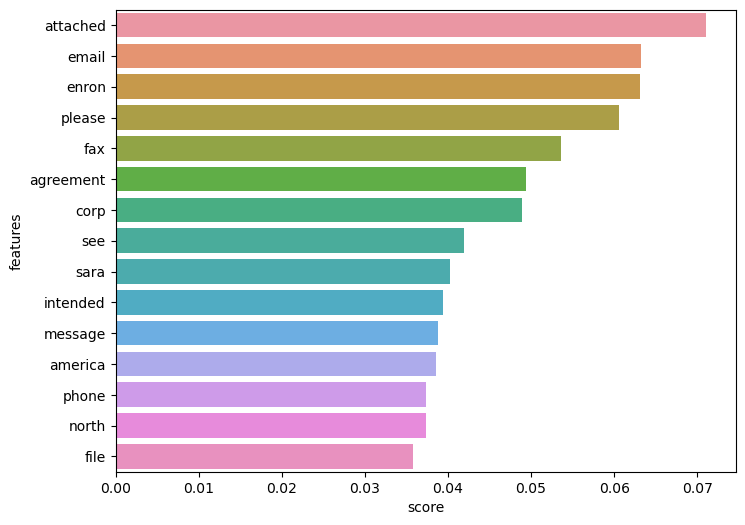

In [213]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])

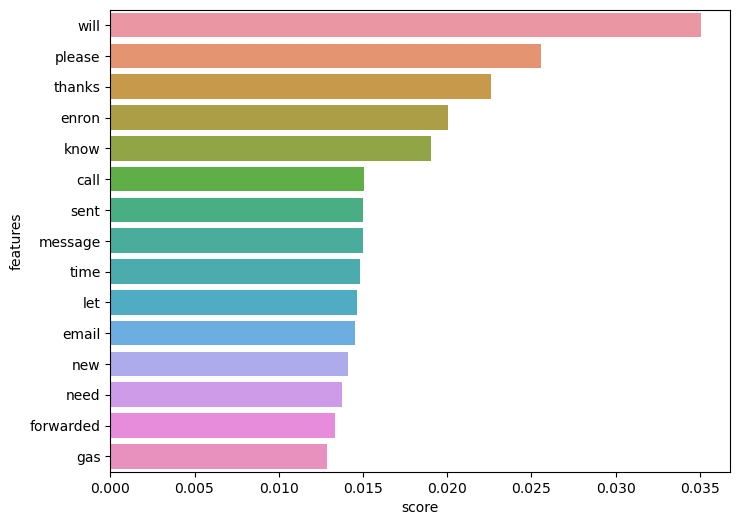

In [214]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])

In [215]:
# for i, df in enumerate(dfs):
#     df.to_csv('df_'+str(i)+'.csv')

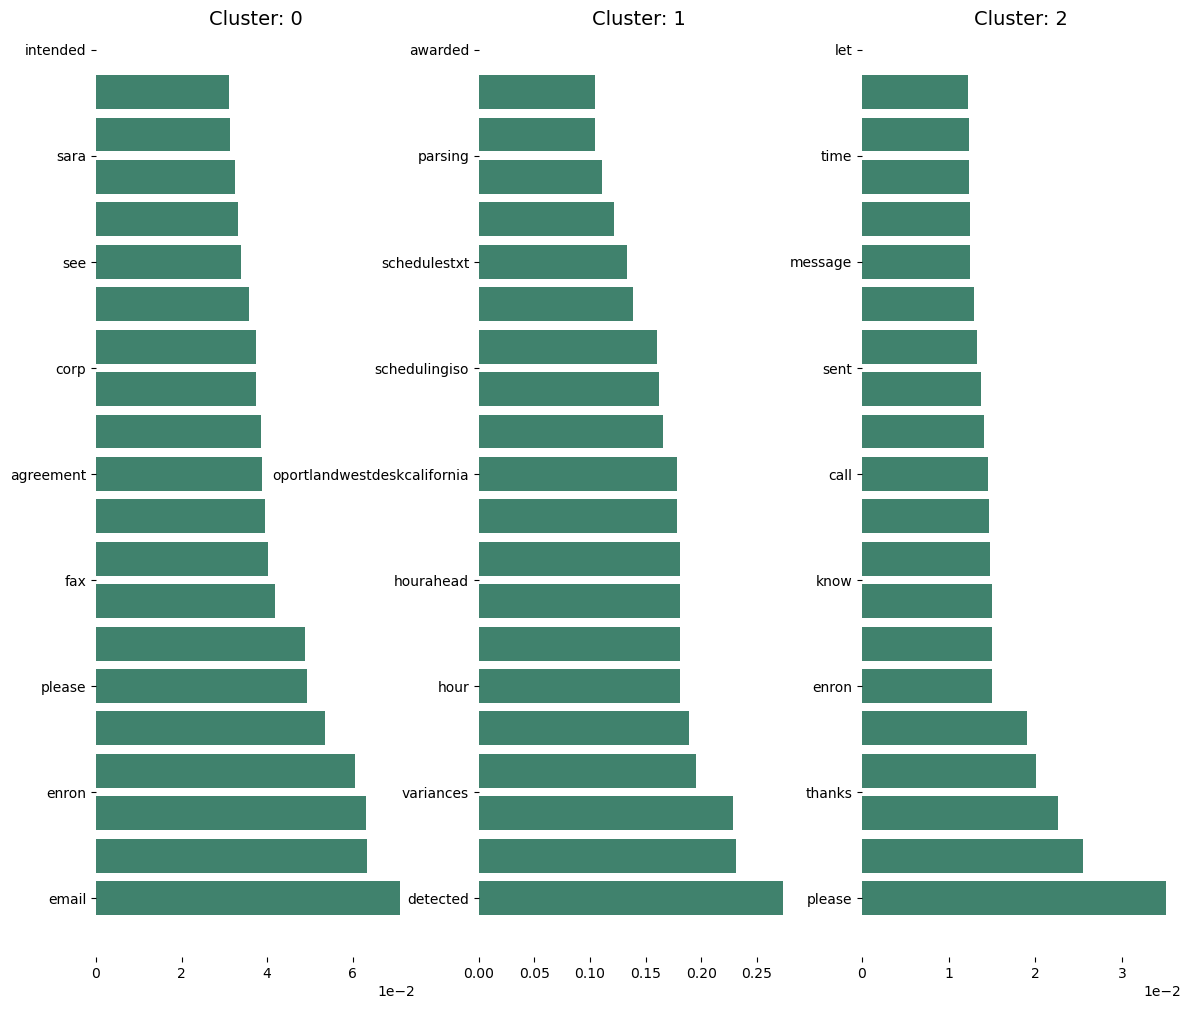

In [216]:
def plot_features(dfs):
    fig = plt.figure(figsize=(14,12))
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.set_title("Cluster: "+ str(i), fontsize = 14)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#40826d')
        yticks = ax.set_yticklabels(df.features)
    plt.show();
plot_features(dfs)